In [1]:
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd/fangming/CEMBA/scripts/ClusterCrossValidation')
import importlib


from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca
from sklearn.model_selection import KFold
import pickle

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import cluster_cv_utils
importlib.reload(cluster_cv_utils)
from cluster_cv_utils import *


# Configs  

In [2]:
log = snmcseq_utils.create_logger()
logging.info('*')

10/08/2019 01:42:22 PM *


In [3]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons'

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [4]:
ps = [0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 0.8, 1]
mods_selected = [
    'snmcseq_gene',
    'snatac_gene',
    'smarter_cells',
    'smarter_nuclei',
    '10x_cells_v2', 
    '10x_cells_v3',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
    ]
resolutions = [0.1, 0.2, 0.4, 0.8, 1, 2, 3, 4, 6, 8, 12, 16, 20, 30, 40, 60, 80, 100, 120]

logging.info(ps)
logging.info(' '.join(mods_selected))

10/08/2019 01:44:23 PM [0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 0.8, 1]
10/08/2019 01:44:23 PM snmcseq_gene smarter_cells smarter_nuclei


10/08/2019 03:57:36 PM 0.01
10/08/2019 03:57:36 PM snmcseq_gene
10/08/2019 03:58:01 PM Cluster chrom: [13 18 10 11  5 14  9 20  2], feature chrom [ 1 16 15 19 12  7  6  4  3  8 17]
10/08/2019 03:58:01 PM Finish split: (4754, 94) -> (2052, 94) (2540, 94)


(4754, 9366) 24.354843378067017
(94, 32) (4754, 94)
(94, 32)


10/08/2019 03:58:01 PM Saved to /cndd/fangming/test_outputs/cluster_cv_single_mop_cv_one_dataset_p1_snmcseq_gene_191008_0.tsv


0.1.....0.2.....0.4.....0.8.....1.....2.....3.....4.....6...

/cndd/fangming/CEMBA/scripts/ClusterCrossValidation/cluster_cv_utils.py:198: RuntimeWarning: Mean of empty slice.
  mse = (diff**2).sum(axis=1).mean()
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


..8.....12.....16.....20.....30.....40.....60.....80.....100.....120.....

10/08/2019 03:58:08 PM Cluster chrom: [ 3 11  9  8  7 15  5  4], feature chrom [10 19  2 17  1  6 12 13 18 14 20 16]
10/08/2019 03:58:08 PM Finish split: (4754, 94) -> (2320, 94) (2272, 94)
10/08/2019 03:58:08 PM Saved to /cndd/fangming/test_outputs/cluster_cv_single_mop_cv_one_dataset_p1_snmcseq_gene_191008_1.tsv


0.1.....0.2.....0.4.....0.8.....1.....2.....3.....4.....6.....8.....12.....16.....20.....30.....40.....60.....80.....100.....120....

10/08/2019 03:58:15 PM Cluster chrom: [ 8 18 19 15  9 20  2 10  3  7], feature chrom [ 6 14 16 12 17  5 11  1 13  4]
10/08/2019 03:58:15 PM Finish split: (4754, 94) -> (2149, 94) (2443, 94)


.

10/08/2019 03:58:15 PM Saved to /cndd/fangming/test_outputs/cluster_cv_single_mop_cv_one_dataset_p1_snmcseq_gene_191008_2.tsv


0.1.....0.2.....0.4.....0.8.....1.....2.....3.....4.....6.....8.....12.....16.....20.....30.....40.....60.....80.....100.....120.....

10/08/2019 03:58:22 PM Cluster chrom: [11  3 16  4 19  1  9 10 20  6], feature chrom [15  8  7  2 12 18  5 17 14 13]
10/08/2019 03:58:22 PM Finish split: (4754, 94) -> (2267, 94) (2325, 94)
10/08/2019 03:58:23 PM Saved to /cndd/fangming/test_outputs/cluster_cv_single_mop_cv_one_dataset_p1_snmcseq_gene_191008_3.tsv


0.1.....0.2.....0.4.....0.8.....1.....2.....3.....4.....6.....8.....12.....16.....20.....30.....40.....60.....80.....100.....120.....

10/08/2019 03:58:30 PM Cluster chrom: [20 13 18  6  9 15  5 17  2 16], feature chrom [14  8 12  3 10 11  7  4  1 19]
10/08/2019 03:58:30 PM Finish split: (4754, 94) -> (2019, 94) (2573, 94)
10/08/2019 03:58:30 PM Saved to /cndd/fangming/test_outputs/cluster_cv_single_mop_cv_one_dataset_p1_snmcseq_gene_191008_4.tsv


0.1.....0.2.....0.4.....0.8.....1.....2.....3.....4.....6.....8.....12.....16.....20.....30.....40.....60.....80.....100.....120.....

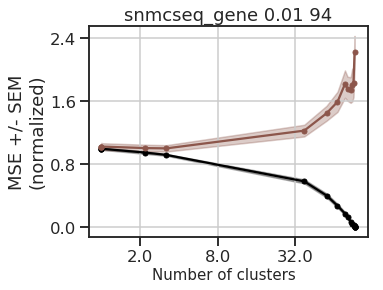

In [31]:
for p, mod in itertools.product(ps, mods_selected):
    logging.info(p)
    logging.info(mod)
    
    name = 'mop_cv_one_dataset_p{}_{}_191008'.format(int(p*100), mod)
    outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
    output_results = outdir + '/cross_validation_results_{}.pkl'.format(name)
    output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
    output_prefix =  '/cndd/fangming/test_outputs/cluster_cv_single_{}'.format(name)

    # gene chrom lookup
    chroms = np.arange(1, 20, 1).tolist() + ['X']
    chroms = ['chr'+str(chrom) for chrom in chroms]

    f = PATH_GENEBODY_ANNOTATION
    df_genes = pd.read_csv(f, sep="\t")
    # modify this
    
    # gene_chrom_lookup
    df_genes = df_genes[df_genes['chr'].isin(chroms)]
    df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
    df_genes = df_genes.set_index('gid')
    gene_chrom_lookup = df_genes['chr'].replace('chrX', 'chr20').apply(lambda x: int(x[3:]))
    # 1:20

    metadata = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)

    ti = time.time()
    if settings[mod].mod_category == 'mc':
        f_mat = hvftrs_f.format(mod, 'tsv')
        gxc_hvftr = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
        assert np.all(gxc_hvftr.columns.values == metadata.index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
        print(gxc_hvftr.shape, time.time()-ti)
    else: 
        f_mat = hvftrs_f.format(mod, 'npz')
        f_gene = hvftrs_gene.format(mod)
        f_cell = hvftrs_cell.format(mod)
        _gxc_tmp = snmcseq_utils.load_gc_matrix(f_gene, f_cell, f_mat)
        _gene = _gxc_tmp.gene
        _cell = _gxc_tmp.cell
        _mat = _gxc_tmp.data

        gxc_hvftr = pd.DataFrame(_mat.todense(), index=_gene, columns=_cell)
        assert np.all(gxc_hvftr.columns.values == metadata.index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
        print(gxc_hvftr.shape, time.time()-ti)
        
    # subsample cells
    if 1 - p > 1e-5:
        metadata_sub, gxc_hvftr_sub = subsampling_lite(metadata, gxc_hvftr, p)
        print(metadata_sub.shape)
    else:
        metadata_sub = metadata
        gxc_hvftr_sub = gxc_hvftr
        print(metadata_sub.shape)

    # do cv
    (
     res_nclsts, res, 
    ) = nfoldcv_random_features_split(gxc_hvftr_sub, resolutions, gene_chrom_lookup,
                                      output_prefix,
                                      k=30, 
                                      reduce_dim=0,
                                      nfolds=5, n_repeats=5, n_splits=5, split_frac=0.5, 
                                     )

    # Saving the objects:
    with open(output_results, 'wb') as f: 
        pickle.dump((
                     res_nclsts, res,
                    ), f)

    # Getting back the objects:
    with open(output_results, 'rb') as f: 
        (
         res_nclsts, res,
        ) = pickle.load(f)

    res_nclsts_summary = res_nclsts.groupby('resolution').agg({'nclsts': ['mean', 'std']})
    res_summary = res.groupby(['resolution']).agg({'mse': ['mean', 'std'],
                                                          'mse_t': ['mean', 'std'],
                                                        })

    output = output_figures.format('cluster_cv_nosharey', 'pdf')
    scale = 1
    fig, ax = plt.subplots(1, 1, figsize=(5*scale,4*scale))

    n_folds = 5

    x = res_nclsts_summary['nclsts']['mean'].values
    ys = res_summary #.xs(mod, level='mod')
    base_level = np.nanmin(ys['mse']['mean'].values)
    y, y_err = ys['mse']['mean'].values/base_level, (ys['mse']['std'].values/np.sqrt(n_folds))/base_level, 
    yt, yt_err = ys['mse_t']['mean'].values/base_level, (ys['mse_t']['std'].values/np.sqrt(n_folds))/base_level, 

    ylabel = 'MSE +/- SEM\n(normalized)'
    xlabel = ''
    plot_bi_cv_subfig(ax, x, 
                      y, y_err,
                      yt, yt_err,
                      settings[mod].color, mod, 
                      xlabel=xlabel,
                      ylabel=ylabel
                     )
    ax.yaxis.set_major_locator(mtick.MaxNLocator(4))
    ax.set_title('{} {} {}'.format(mod, p, len(metadata_sub)))

    fig.subplots_adjust(wspace=0.1, bottom=0.15)
    fig.text(0.5, 0, 'Number of clusters', ha='center', fontsize=15)
    fig.savefig(output, bbox_inches='tight')
    plt.show()
    
    break